In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

from learner.metric.dynamics_metric import (
    calculate_dynamics_metrics,
    plot_dynamics_metrics,
)

/home/lbu/project/PINN_DE


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-08-25 20:38:44 INFO ####################################################################################################


# system

In [3]:
##################################################################
#
# load data and net
#
##################################################################
# Dasetset  
config_file_path = "/home/lbu/project/PINN_DE/configs/train/sp/config_pinn.py"
config = read_config_file(config_file_path)
config.dataset_path = "/home/lbu/project/PINN_DE/outputs/data/DynamicSinglePendulumDAE"

data_args = {
    "config": config,
    "logger": logger,
}
data = ln.data.get_data(**data_args)
train_loader, val_loader = data
y0, y, yt, data_t, physics_t = next(iter(val_loader))

data_t, y, yt = tensors_to_numpy(data_t, y, yt)
q, qt = np.split(y, 2, axis=-1)
qt, qtt = np.split(yt, 2, axis=-1)
all_states = np.concatenate([q, qt, qtt], axis=-1)

##################################################################
#
# Calculate the error
#
##################################################################
from dynamics import DynamicSinglePendulumDAE
calculator = DynamicSinglePendulumDAE(config, logger).calculator

energy = calculator.energy(q, qt) 
energy_error = calculator.energy(q, qt) - calculator.energy(q, qt)[0]

phi = calculator.phi(q, qt, qtt)
phi_t = calculator.phi_t(q, qt, qtt)
phi_tt = calculator.phi_tt(q, qt, qtt)
kinetic = calculator.kinetic(q, qt)
potential = calculator.potential(q, qt)

2023-08-25 20:38:44 INFO =================>
2023-08-25 20:38:44 INFO Start get dataset...
2023-08-25 20:38:44 INFO Loading dataset from path: /home/lbu/project/PINN_DE/outputs/data/DynamicSinglePendulumDAE
2023-08-25 20:38:44 INFO DynamicData is loaded


In [4]:
y.shape, physics_t.shape, y0.shape

((501, 4), torch.Size([1000, 1]), torch.Size([1, 4]))

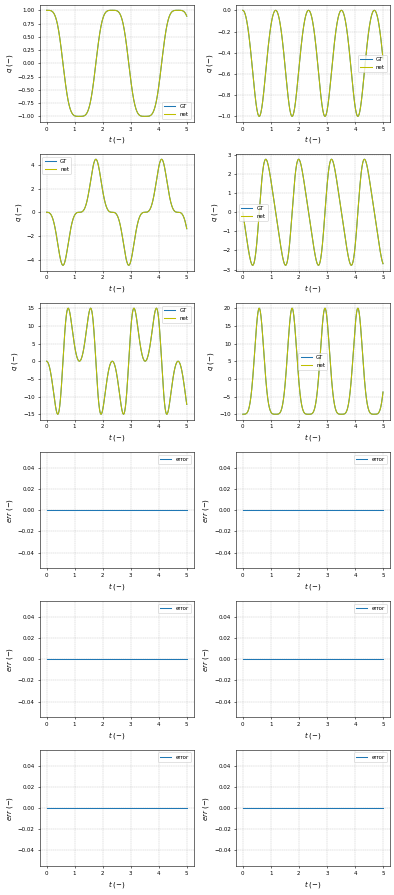

In [5]:
plot_dynamics_metrics(
    config=config,
    pred_data=[q, qt, qtt],
    gt_data=[q, qt, qtt],
    t=data_t,
)

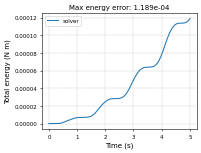

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(4 * 1, 3 * 1), dpi=DPI)
subfig = axs
subfig.set_title('Max energy error: {:.3e}'.format(np.max(np.abs(energy_error))))
plt.xlabel('Time (s)')
plt.ylabel('Total energy (N m)')
subfig.plot(data_t, energy, '-', label='solver')
subfig.legend()

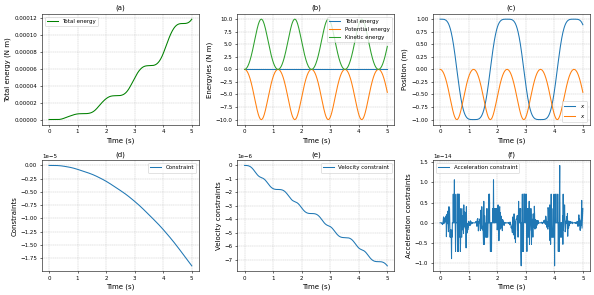

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=DPI)

subfig = axs[0, 0]
subfig.set_title('(a)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Total energy (N m)')
subfig.plot(data_t, energy, 'g-', label='Total energy')
subfig.legend()

subfig = axs[0, 1]
subfig.set_title('(b)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Energyies (N m)')
subfig.plot(data_t, energy, label='Total energy')
subfig.plot(data_t, potential, label='Potential energy')
subfig.plot(data_t, kinetic, label='Kinetic energy')
subfig.legend()

subfig = axs[0, 2]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Position (m)')
subfig.plot(data_t, q[:, ], label=r'$x$')
subfig.legend()

subfig = axs[1, 0]
subfig.set_title('(d)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Constraints')
subfig.plot(data_t, phi[:, ], label='Constraint')
subfig.legend()

subfig = axs[1, 1]
subfig.set_title('(e)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity constraints')
subfig.plot(data_t, phi_t[:, ], label='Velocity constraint')
subfig.legend()

subfig = axs[1, 2]
subfig.set_title('(f)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Acceleration constraints')
subfig.plot(data_t, phi_tt[:, ], label='Acceleration constraint')
subfig.legend()

plt.tight_layout()

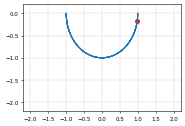

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# 设置参数
fps = 30  # 帧率
duration = len(data_t) # 动画持续时间（秒）
num_frames = int(duration / fps) # 帧数

# 创建动画
fig, axs = plt.subplots(1, 1, figsize=(4, 3 ), dpi=DPI)
subfig = axs
subfig.set_title('Animation')
subfig.set_xlabel('Position (m)')
subfig.set_ylabel('Position (m)')
subfig.plot(q[:, 0], q[:, 1])    
subfig.scatter(q[0, 0], q[0, 1], color='red', marker='o')    
plt.tight_layout()

def animate(frame):
    current = int(frame * fps)
    subfig.clear()
    subfig.plot(q[:current, 0], q[:current, 1])    
    subfig.scatter(q[current, 0], q[current, 1], color='red', marker='o')    
    subfig.set_xlim(-2.2, 2.2)  
    subfig.set_ylim(-2.2, 0.2)  
    return []


ani = FuncAnimation(fig, animate, frames=num_frames, blit=True)

# # 保存为GIF文件
path = os.path.join(output_dir,'animation.gif')
ani.save(path, writer='pillow')